In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder, label_binarize, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (f1_score, roc_auc_score, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay,
                             roc_curve, average_precision_score, accuracy_score,classification_report)

In [2]:
df = pd.read_csv('../data/creditcard.csv')

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# ML Models

## Characteristic Selection

### Random Forest for characteristic selection

In [13]:
# Function to evaluate model performance
def evaluate_model(model, train_features, train_target, test_features, test_target,classes):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(2, 3, figsize=(20, 12)) 
    
    for type, features, target in (
        ('train', train_features, train_target),
        ('test', test_features, test_target)
        ):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:,1]

        # Calculate overall accuracy
        accuracy = accuracy_score(target,pred_target)
        eval_stats[type]['Accuracy'] = accuracy

        # Calculate and print classification report
        class_report = classification_report(target,pred_target,target_names=classes, output_dict=True)
        eval_stats[type]['Precision'] = class_report['weighted avg']['precision']
        eval_stats[type]['Recall'] = class_report['weighted avg']['recall']
        eval_stats[type]['F1'] = class_report['weighted avg']['f1-score']
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot confusion Matrix
        ax = axs[0,0] if type == 'train' else axs[1,0]
        cm = confusion_matrix(target,pred_target)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(ax=ax,cmap='Blues')
        ax.set_title(f'{type.capitalize()} Confusion Matrix')

         #Plot Roc curves
        ax = axs[0,1] if type == 'train' else axs[1,1]
        fpr,tpr, _ = roc_curve(target,pred_proba)
        roc_auc = roc_auc_score(target,pred_proba)
        ax.plot(fpr,tpr,label=f'AUC={roc_auc:.2f}', color=color)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{type.capitalize()} ROC Curve')
        ax.legend(loc='lower right')

        # Plot precission recall curves
        ax = axs[0,2] if type == 'train' else axs[1,2]
        precission, recall, _ = precision_recall_curve(target, pred_proba)
        aps = average_precision_score(target, pred_proba)
        ax.plot(recall, precission,label=f'AP={aps:.2f}', color=color)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{type.capitalize()} Precision-Recall Curve')
        ax.legend(loc='upper right')
    
    df_eval_stats = pd.DataFrame(eval_stats).round(2)    
    print(df_eval_stats.reindex(index=('Accuracy', 'Precision', 'Recall', 'F1')))
    plt.tight_layout()
    plt.show()

In [4]:
# We create a function to divide our dataset

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [5]:
# We create a function do devide features from target
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [6]:
# We use the train_test_split to devide or dataset 
train_set, test_set, valid_set = train_val_test_split(df)

In [9]:
# We devide into features and target
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(valid_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

In [10]:
# We create and train our model 
seed = 42
rf_model = RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=seed)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [11]:
# We make predictions using the valid_set
y_pred = rf_model.predict(X_val)

# We print the score

print("F1 score:", f1_score(y_pred, y_val, average='weighted'))

F1 score: 0.9996088926836342


           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


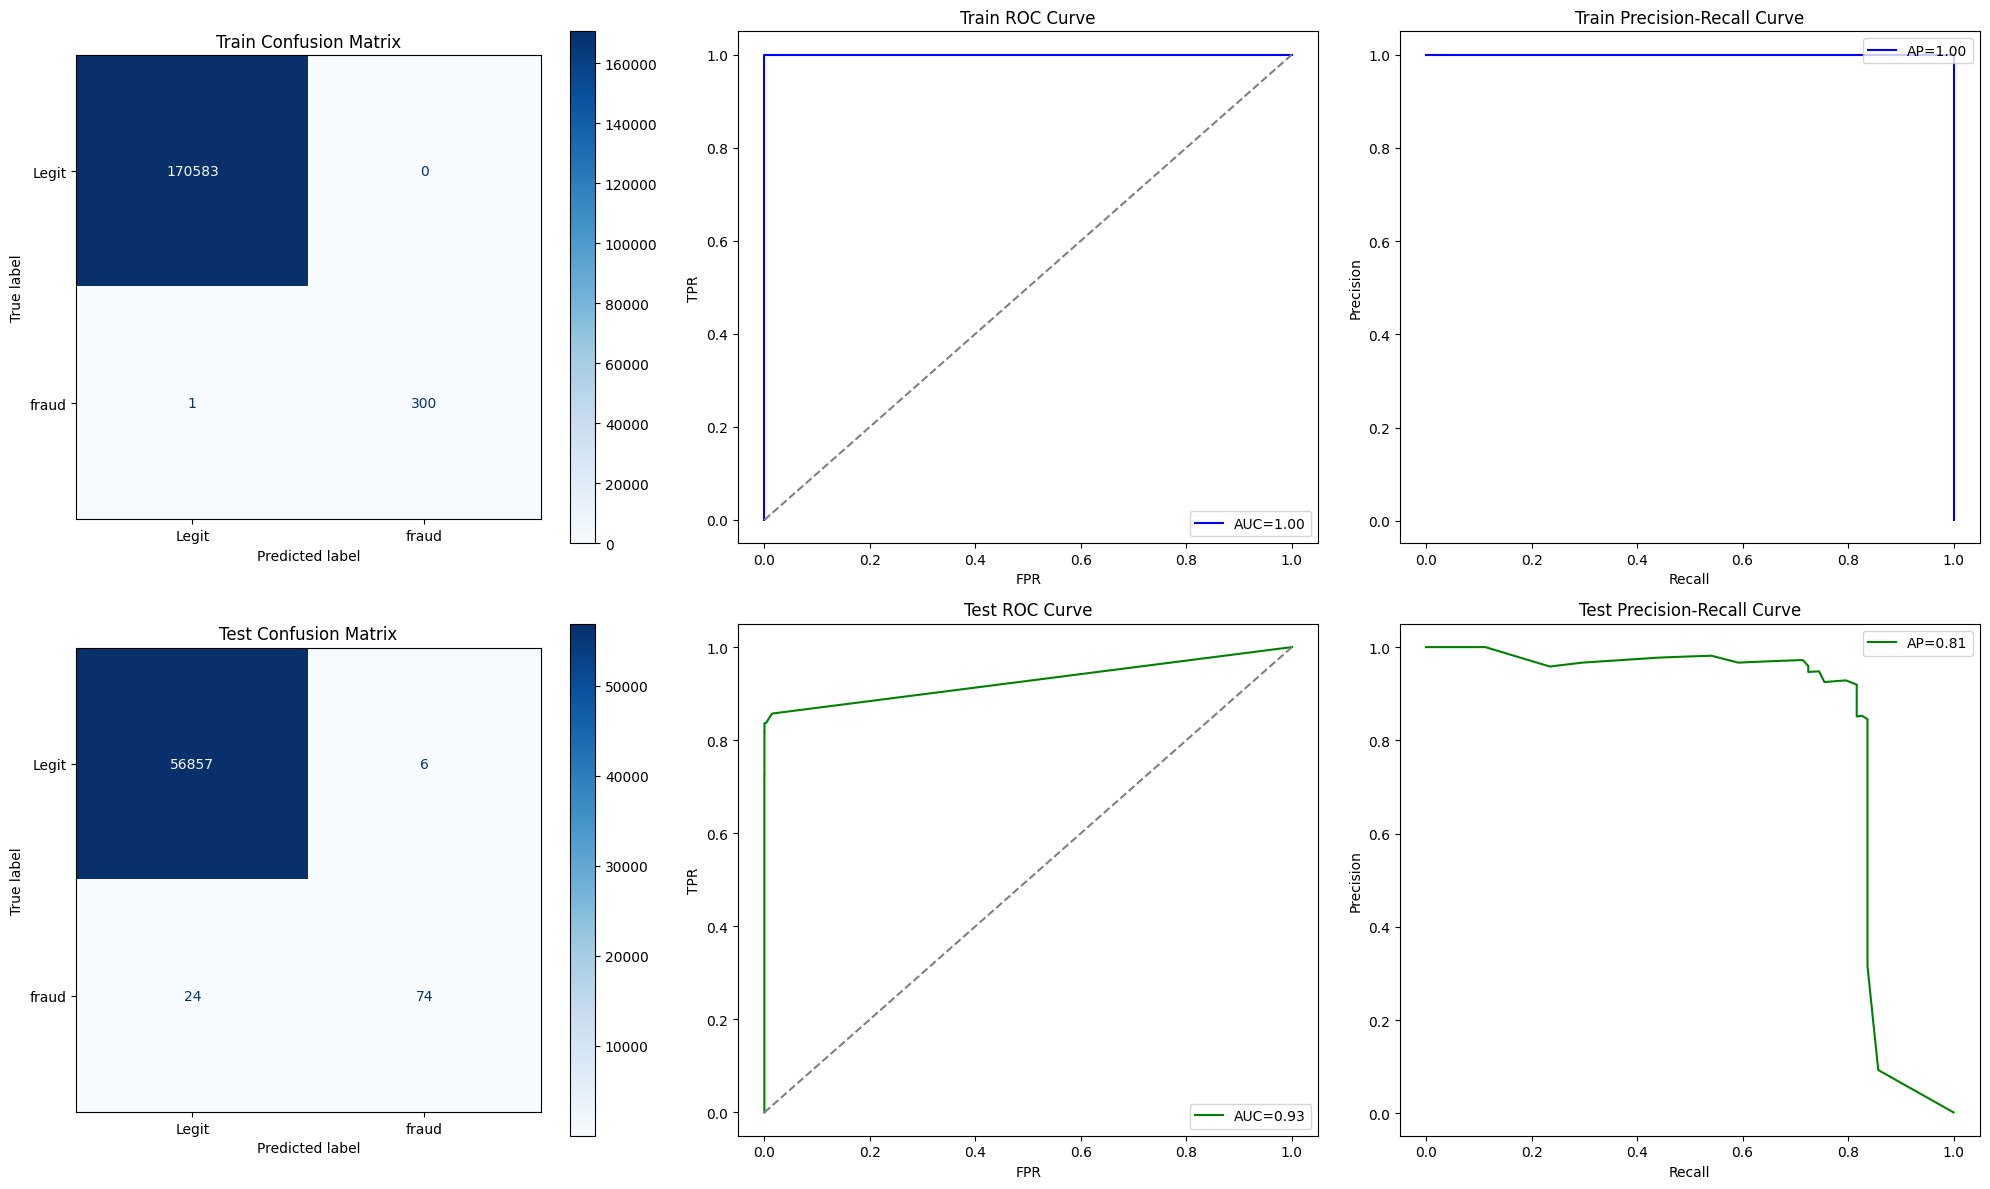

In [14]:
# Evaluate performance
evaluate_model(rf_model,X_train, y_train, X_test, y_test,['Legit','fraud'])

In [15]:
# Feature importance
feature_importances = {name: score for name, score in zip(list(df), rf_model.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(20)

V17       0.175820
V14       0.171744
V12       0.095865
V10       0.076360
V16       0.062539
V11       0.045085
V4        0.028226
V9        0.027054
V18       0.026549
V7        0.025505
V21       0.020619
V1        0.020307
V3        0.020218
V26       0.016280
V20       0.015930
Time      0.014507
Amount    0.013449
V8        0.013384
V2        0.012673
V19       0.012558
dtype: float64

### Reducing Characteristics

In [16]:
# We select the first 10 characteristics regarding their importance in the rf_model
columns_reduced = list(feature_importances_sorted.head(10).index)
columns_reduced

['V17', 'V14', 'V12', 'V10', 'V16', 'V11', 'V4', 'V9', 'V18', 'V7']

In [17]:
X_train_reduced = X_train[columns_reduced].copy()
X_val_reduced = X_val[columns_reduced].copy()
X_test_reduced = X_test[columns_reduced].copy()

### Logistic Regression

c:\Users\ZonaDigital\Documents\3. Repositorios\c19-128-t-data-bi\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


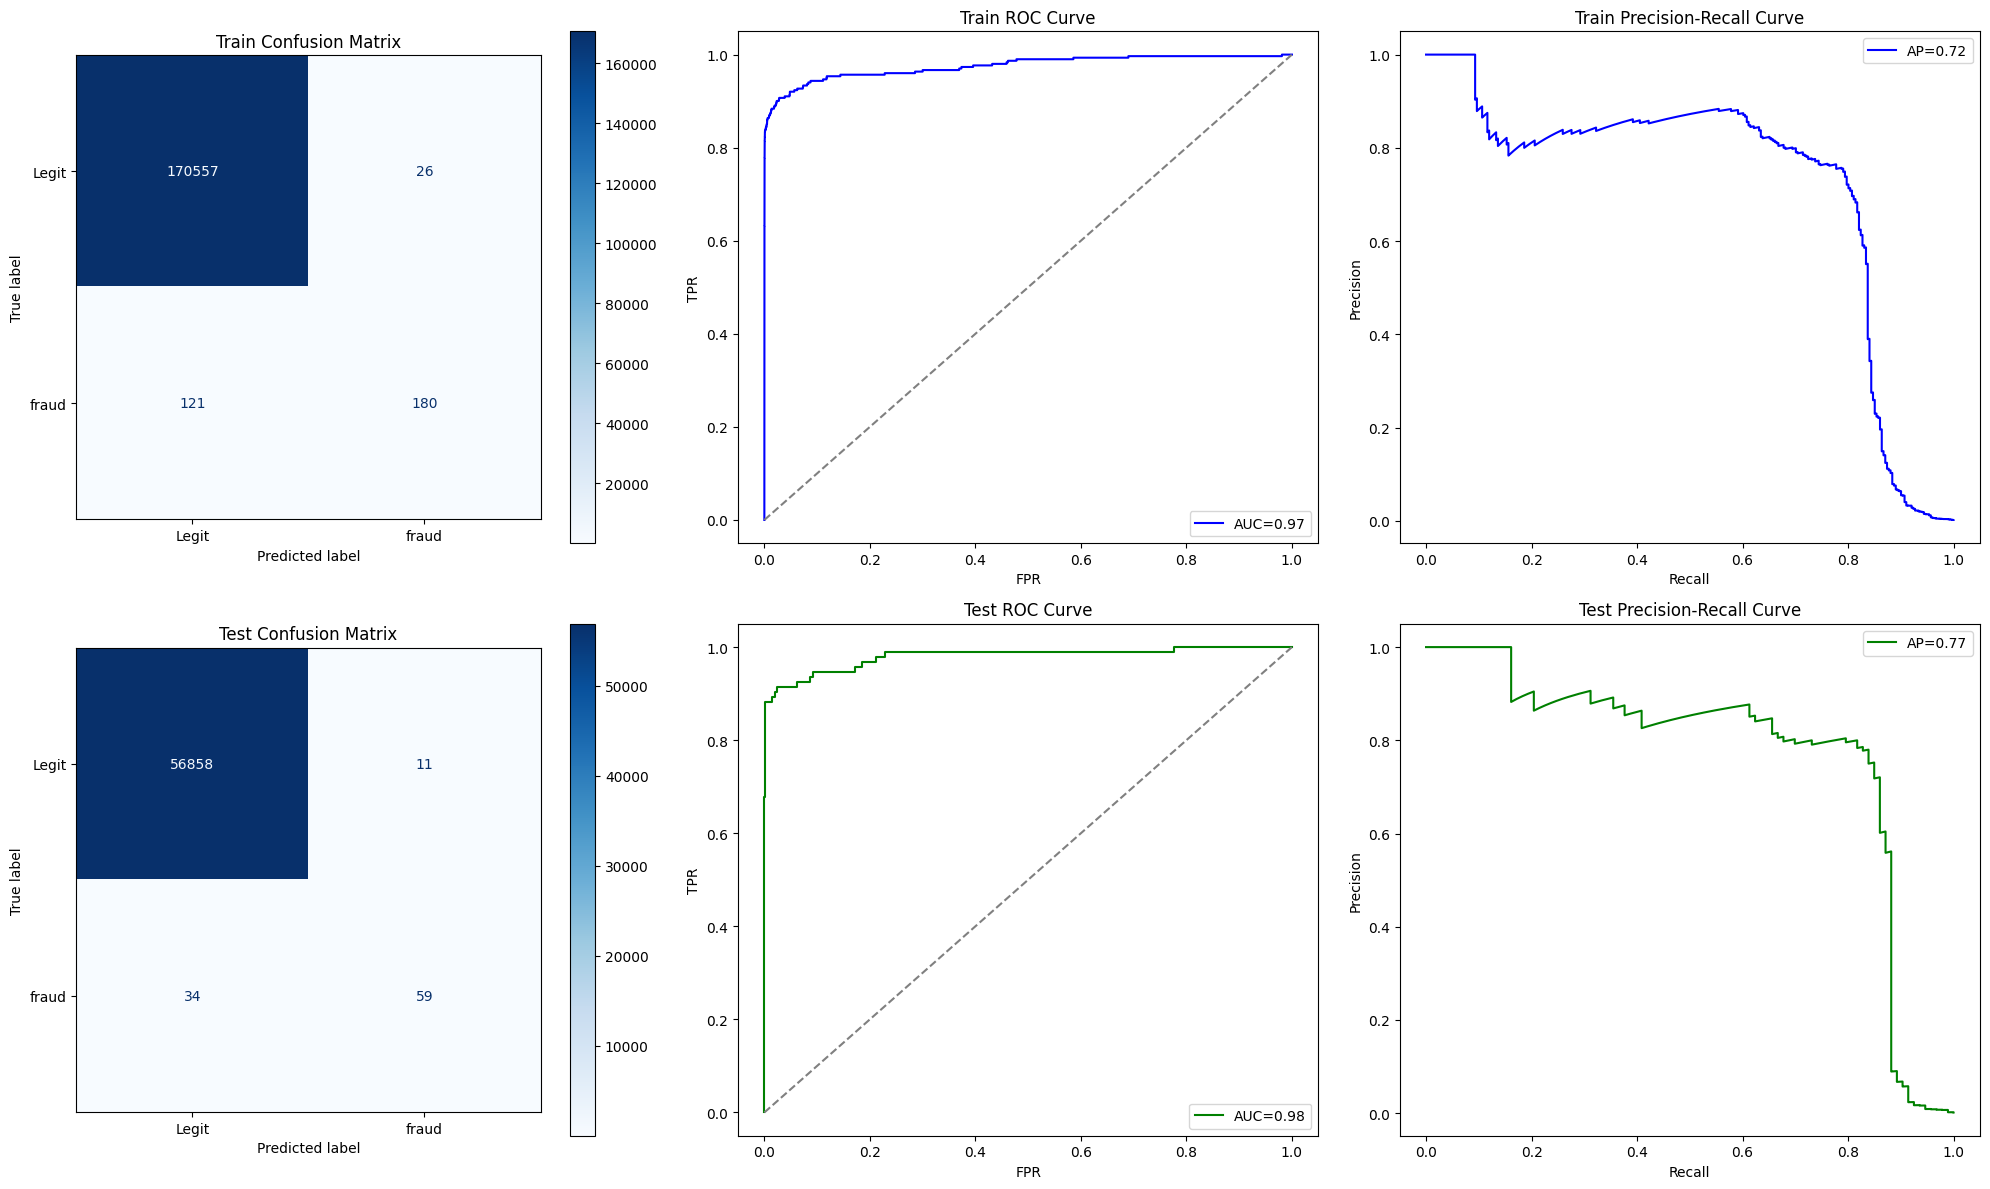

In [19]:
model_lr=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed, max_iter=200)
model_lr.fit(X_train_reduced, y_train)
evaluate_model(model_lr, X_train_reduced, y_train, X_val_reduced, y_val,['Legit','fraud'])

### Decision Tree

In [24]:
model_tree = DecisionTreeClassifier(random_state=seed)
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10]
}
grid_tree = GridSearchCV(estimator=model_tree, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_tree.fit(X_train_reduced, y_train)

print(f'''
Best params:{ grid_tree.best_params_}        
Best score: {grid_tree.best_score_} 
''')


Best params:{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}        
Best score: 0.8979732432458791 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


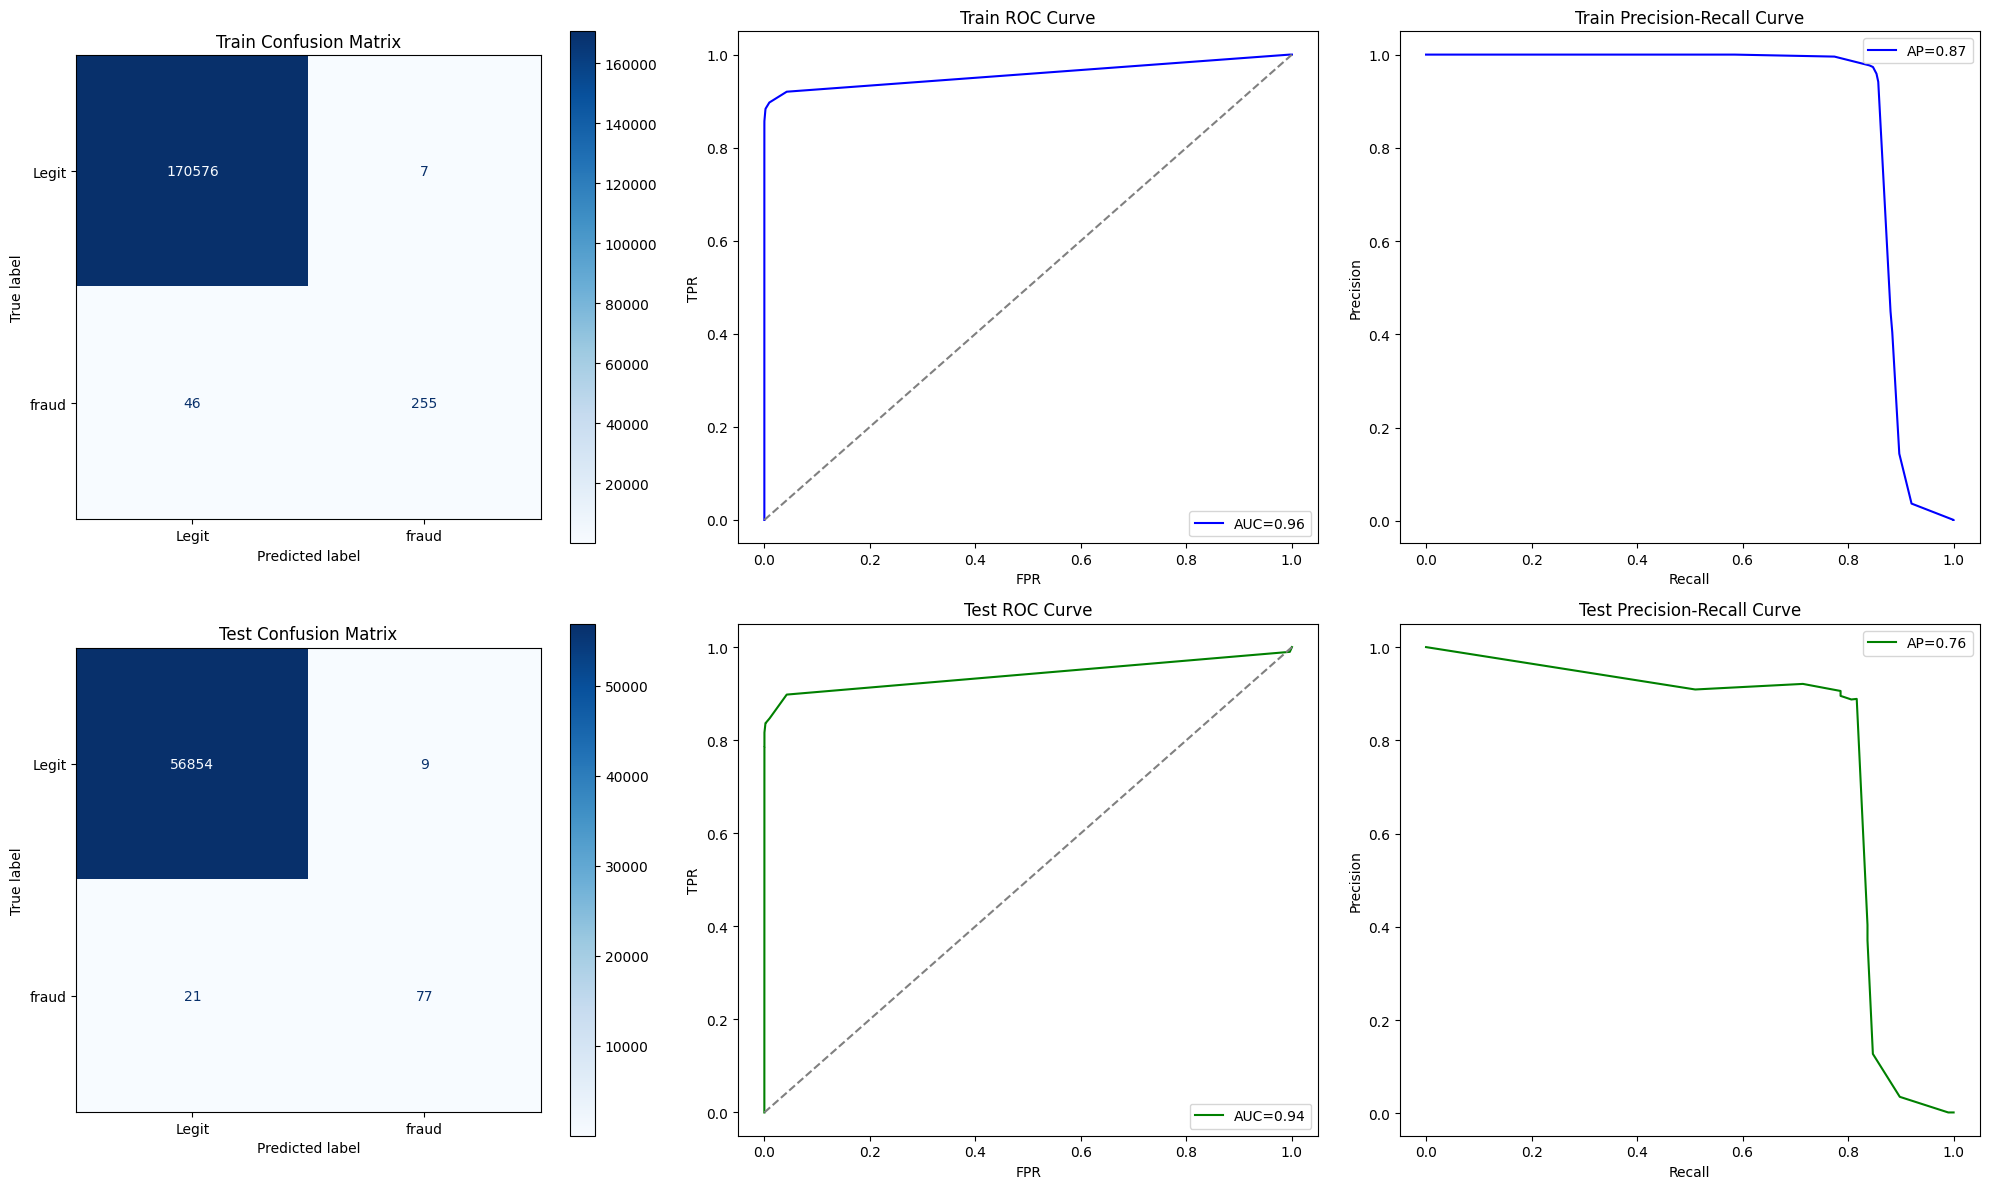

In [25]:
evaluate_model(grid_tree.best_estimator_, X_train_reduced, y_train, X_test_reduced, y_test,['Legit','fraud'])

### Random Forest 

In [22]:
# Using gridserach to find the best model
model_forest = RandomForestClassifier()
param_grid = {
    'n_estimators':[20, 50, 100],
    'criterion':['gini', 'entropy'],
    'max_depth':[10, 20, 30],
    'class_weight':[None, 'balanced']
}
grid_forest = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_forest.fit(X_train_reduced, y_train)

print(f'''
Best params:{ grid_forest.best_params_}        
Best score: {grid_forest.best_score_} 
''')

c:\Users\ZonaDigital\Documents\3. Repositorios\c19-128-t-data-bi\venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best params:{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}        
Best score: 0.999485031363241 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


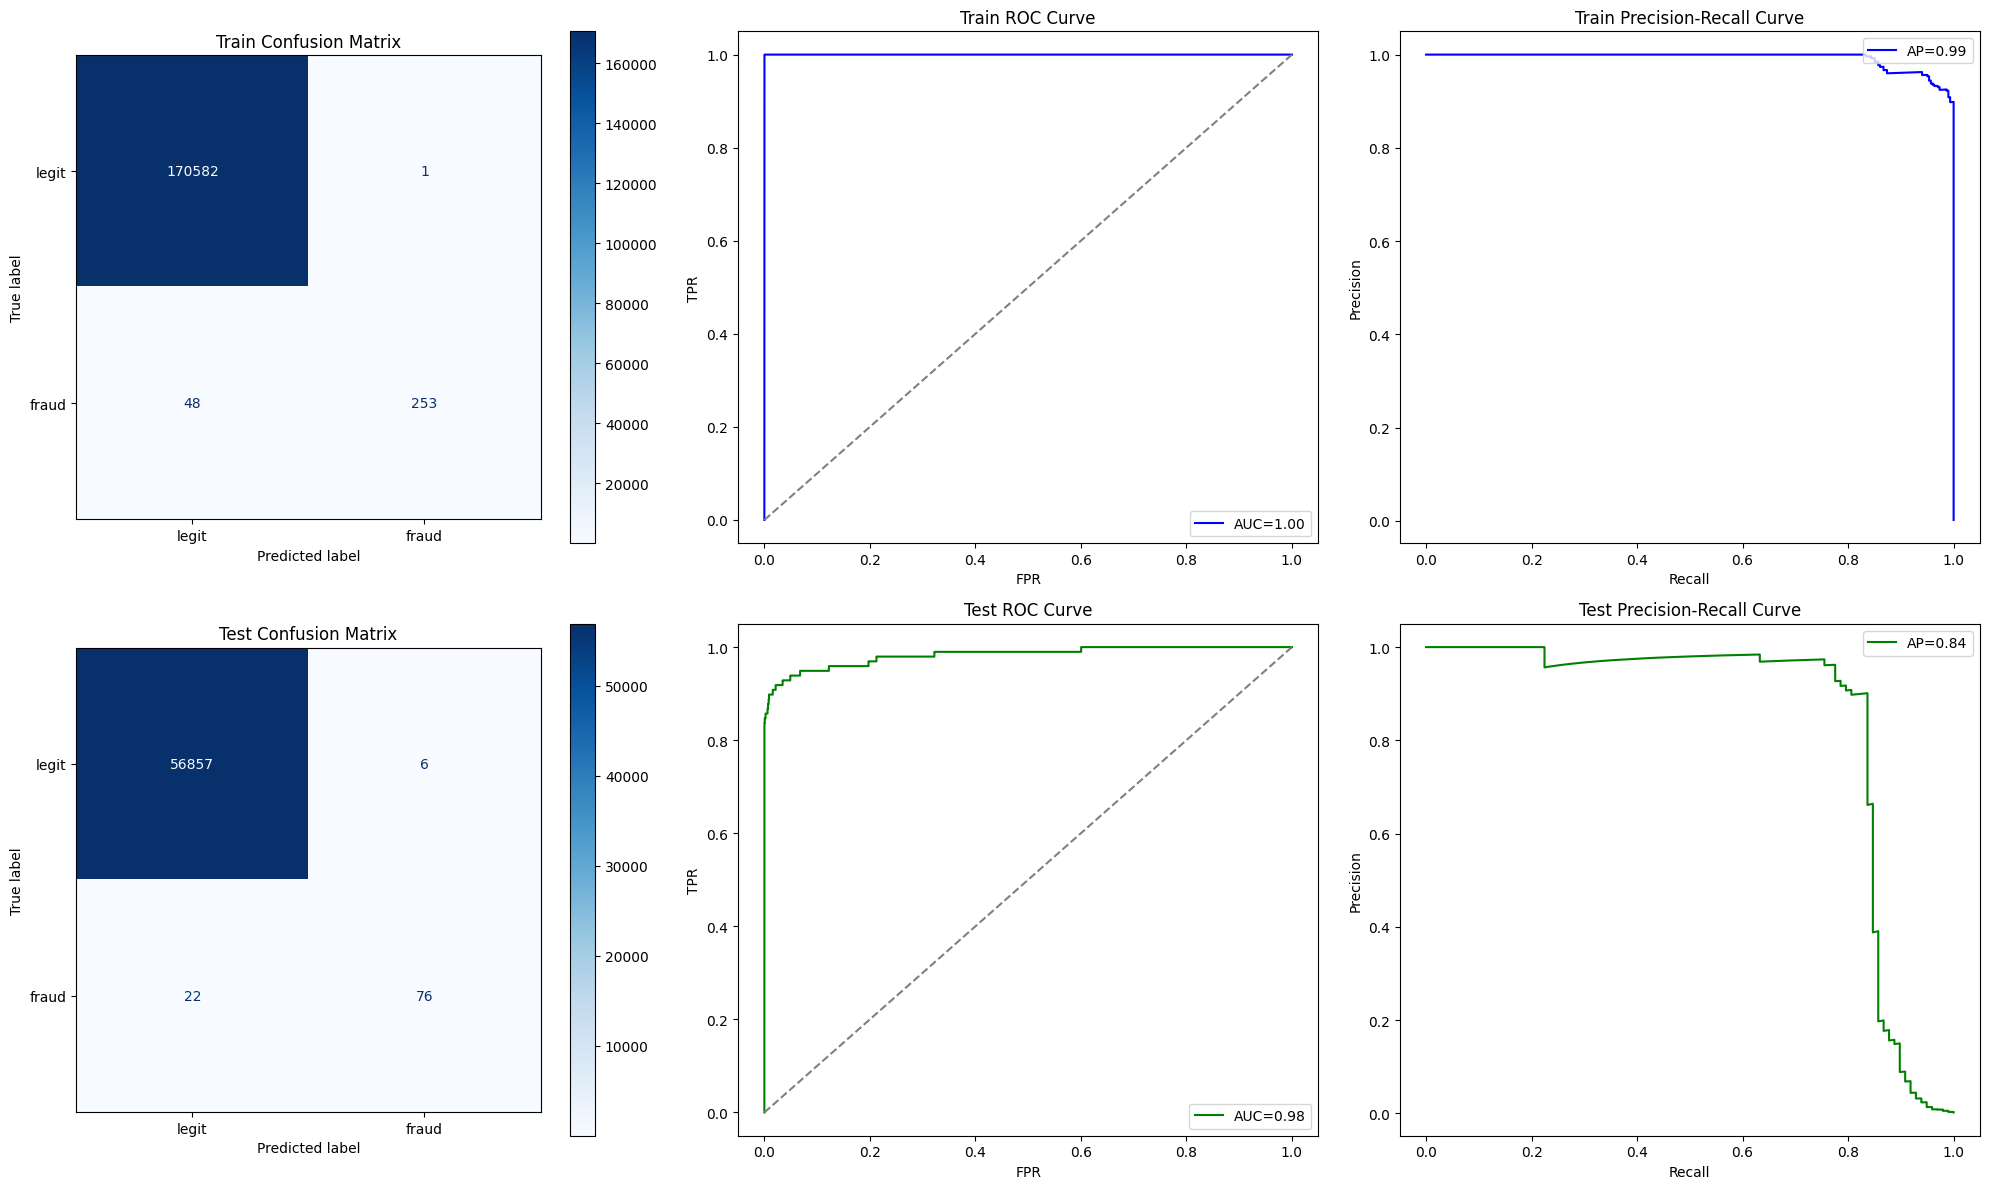

In [23]:
evaluate_model(grid_forest.best_estimator_,X_train_reduced, y_train, X_test_reduced, y_test,['legit','fraud'])

### XB Boost

In [28]:
model_xgb = XGBClassifier(objective='multi:softmax', num_class=3)
param_grid = {
    'n_estimators':[20, 50,100],
    'max_depth':[5, 15, 30],
    'learning_rate':[0.01, 0.05, 0.1],
    'gamma':[0, 0.1, 0.2]
}

grid_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

grid_xgb.fit(X_train_reduced, y_train)

print(f'''
Best params:{ grid_xgb.best_params_}        
Best score: {grid_xgb.best_score_} 
''')


Best params:{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}        
Best score: 0.9734852860165107 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


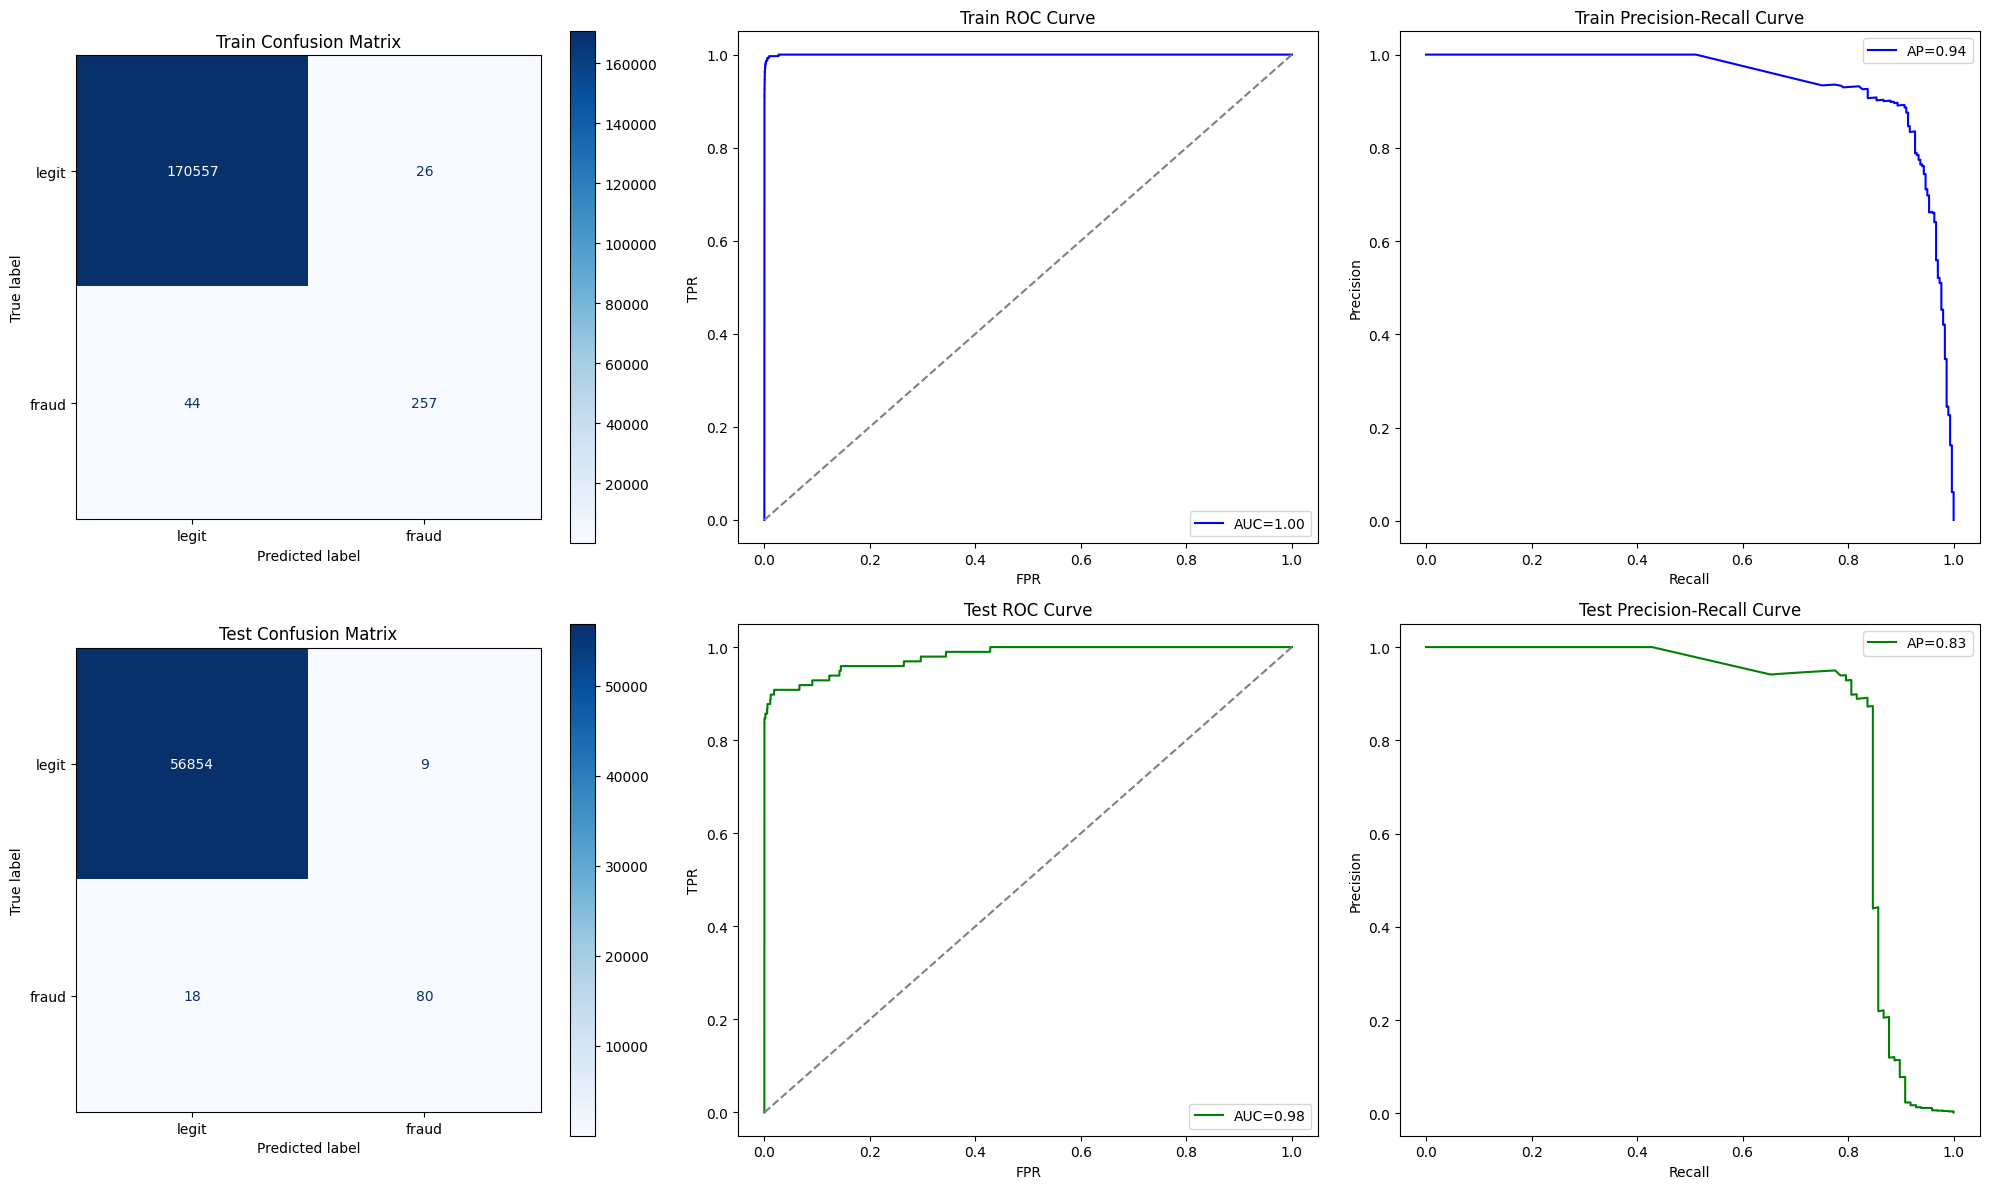

In [30]:
evaluate_model(grid_xgb.best_estimator_,X_train_reduced, y_train, X_test_reduced, y_test,['legit','fraud'])

### LightGBM

In [33]:
model_lgbm = LGBMClassifier(random_state=seed)
param_grid = {
    'n_estimators':[50, 150, 200],
    'max_depth':[5, 15, 30],
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9]
}
grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_lgbm.fit(X_train_reduced, y_train)

print(f'''
Best params:{ grid_lgbm.best_params_}        
Best score: {grid_lgbm.best_score_} 
''')

[LightGBM] [Info] Number of positive: 301, number of negative: 170583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 170884, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001761 -> initscore=-6.339867
[LightGBM] [Info] Start training from score -6.339867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


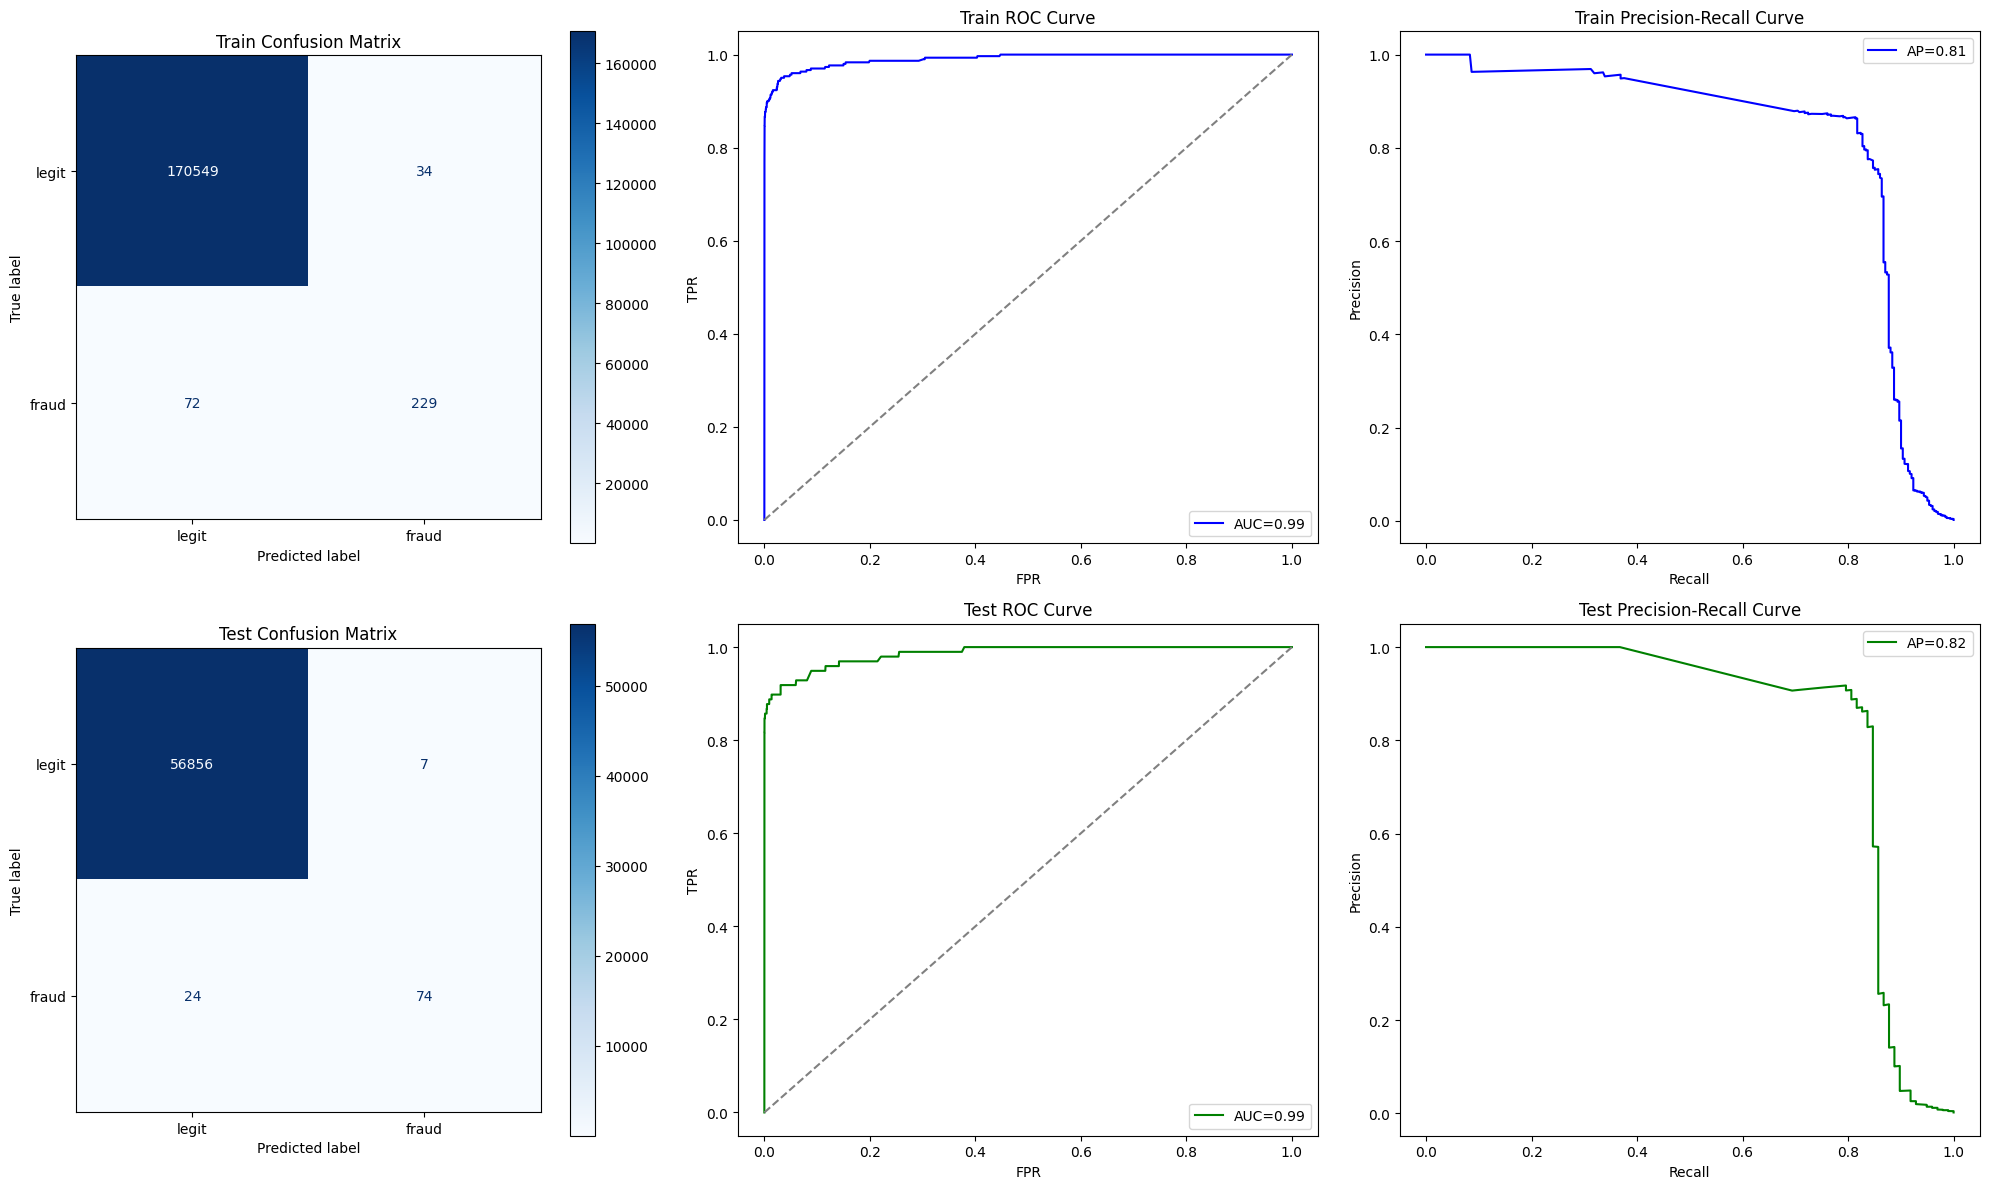

In [34]:
evaluate_model(grid_lgbm.best_estimator_,X_train_reduced, y_train, X_test_reduced, y_test,['legit','fraud'])

### Neural Networks

## ML Models SMOTE 

In [36]:
over_sampler = SMOTE(random_state=seed)
x_usampled,y_upsampled = over_sampler.fit_resample(df[columns_reduced],df['Class'])

In [37]:
print('Resampled dataset shape %s' % Counter(y_upsampled))

Resampled dataset shape Counter({0: 284315, 1: 284315})


In [38]:
df_u = x_usampled.copy()
df_u['class'] = y_upsampled.copy()
train_set_u, valid_set_u, test_set_u = train_val_test_split(df_u)

# We devide into features and target
X_train_u, y_train_u = remove_labels(train_set_u, 'class')
X_val_u, y_val_u = remove_labels(valid_set_u, 'class')
X_test_u, y_test_u = remove_labels(test_set_u, 'class')

### Logistic Regression

c:\Users\ZonaDigital\Documents\3. Repositorios\c19-128-t-data-bi\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


           train  test
Accuracy    0.94  0.94
Precision   0.94  0.94
Recall      0.94  0.94
F1          0.94  0.94


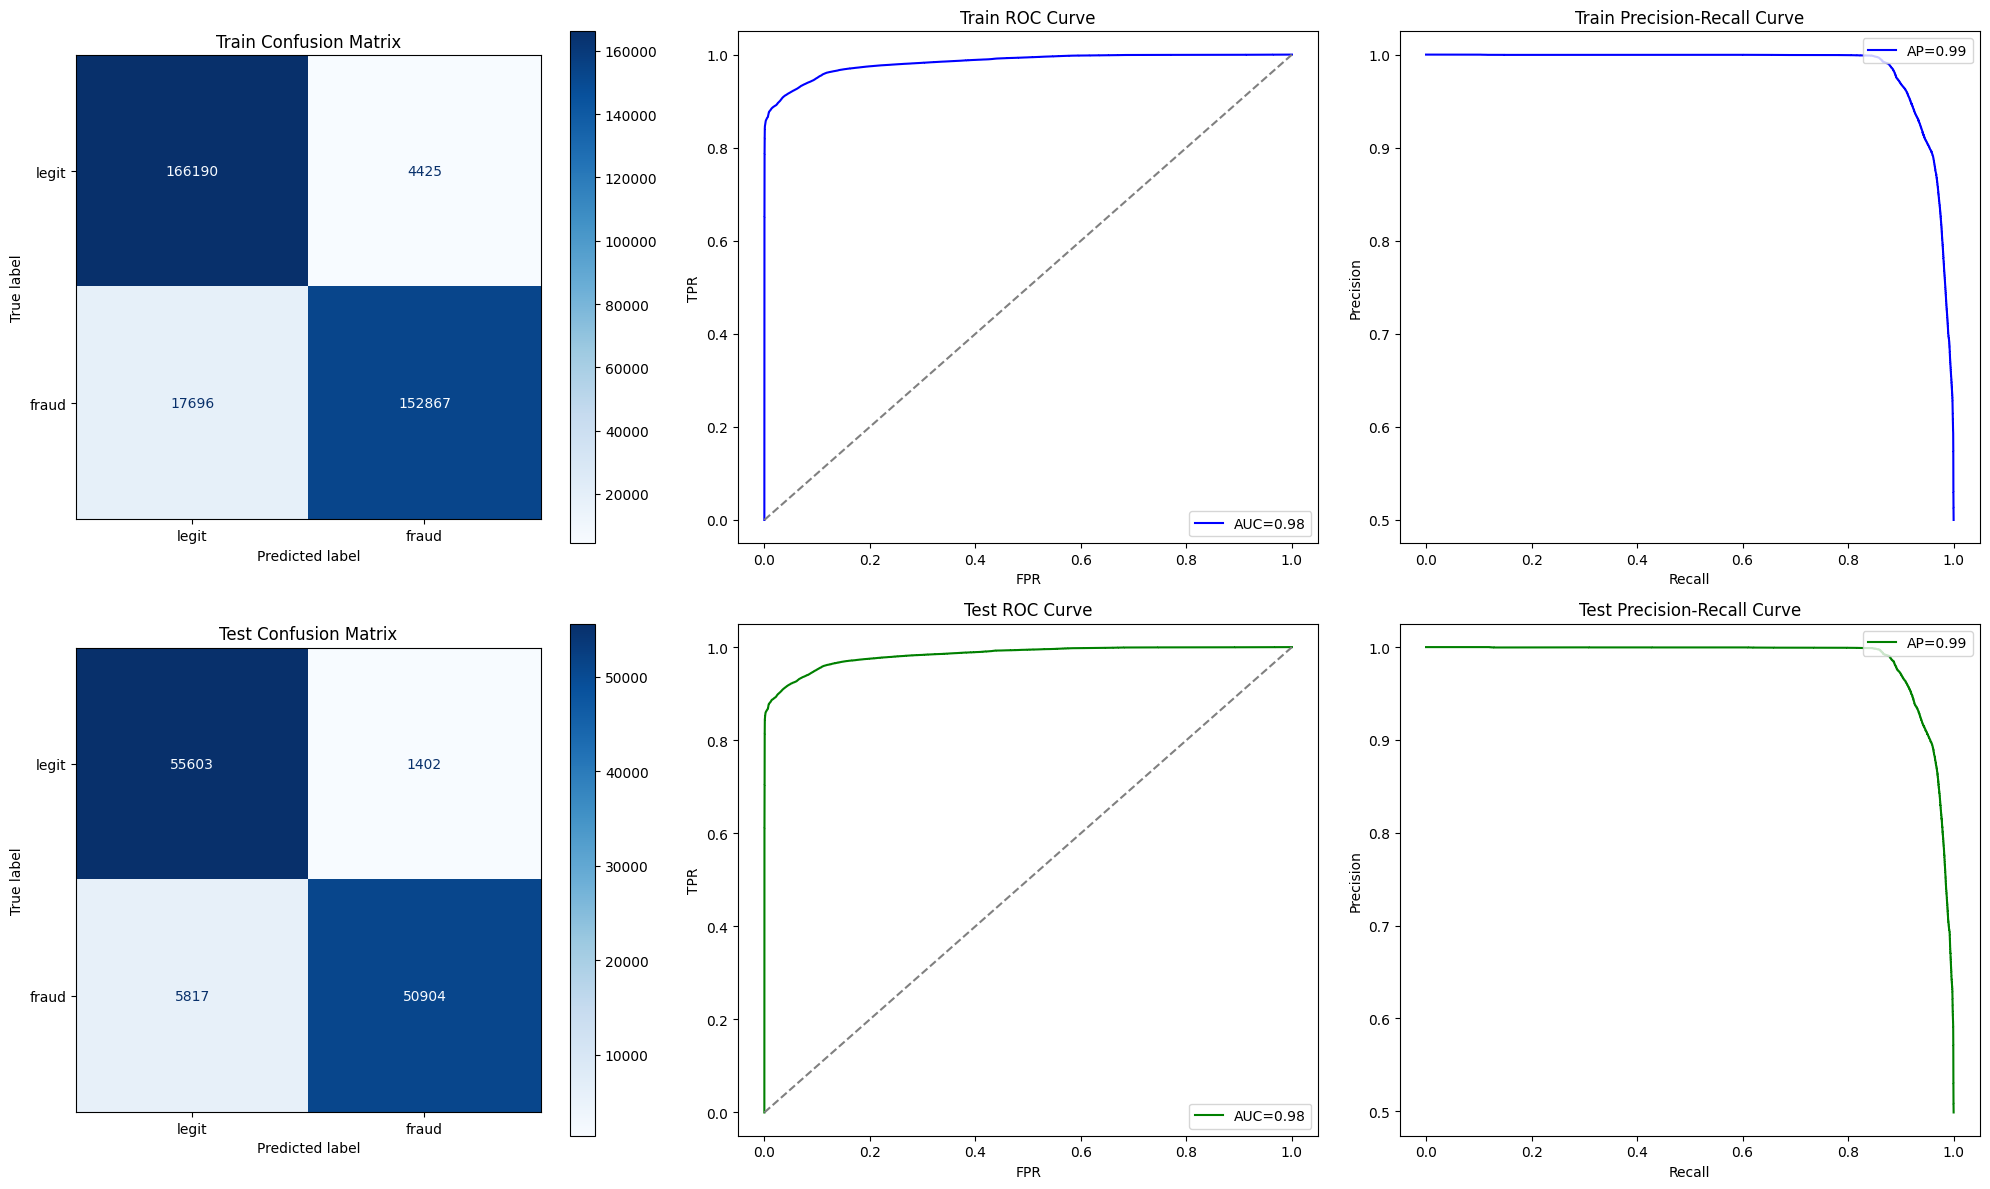

In [39]:
model_lr_u=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=seed, max_iter=200)
model_lr_u.fit(X_train_u, y_train_u)
evaluate_model(model_lr_u, X_train_u, y_train_u, X_val_u, y_val_u,['legit','fraud'])

### Decision Tree

In [40]:
model_tree_u = DecisionTreeClassifier(random_state=seed)
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10]
}
grid_tree_u = GridSearchCV(estimator=model_tree_u, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_tree_u.fit(X_train_u, y_train_u)

print(f'''
Best params:{ grid_tree_u.best_params_}        
Best score: {grid_tree_u.best_score_} 
''')


Best params:{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10}        
Best score: 0.9975016925938484 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


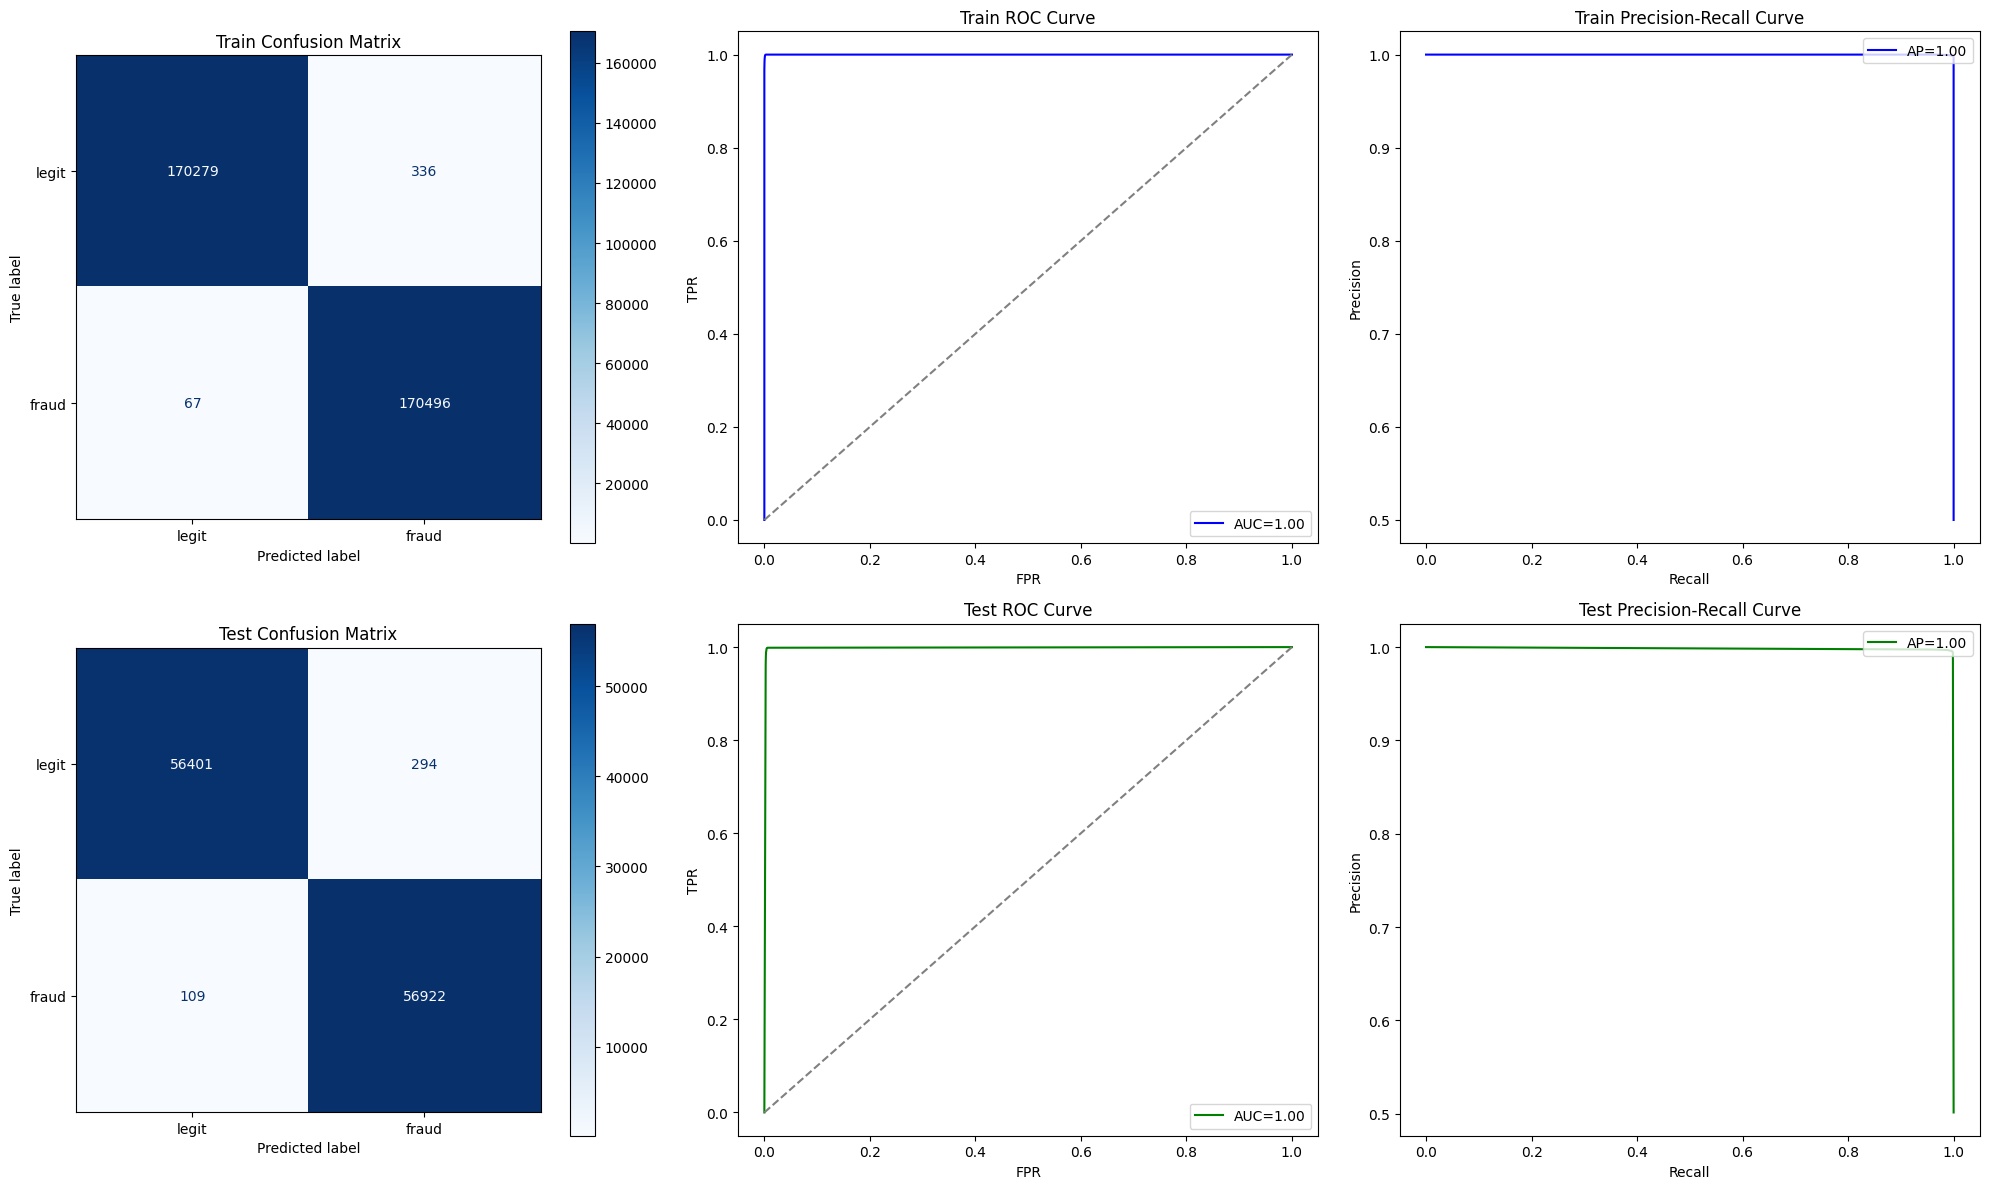

In [42]:
evaluate_model(grid_tree_u.best_estimator_, X_train_u, y_train_u, X_test_u, y_test_u,['legit','fraud'])

### Random Forest

In [43]:
# Using gridserach to find the best model
model_forest_u = RandomForestClassifier(random_state=seed)
param_grid = {
    'n_estimators':[20, 50, 100],
    'criterion':['gini', 'entropy'],
    'max_depth':[10, 20, 30],
    'class_weight':[None, 'balanced']
}
grid_forest_u = GridSearchCV(estimator=model_forest_u, param_grid=param_grid, scoring='roc_auc', cv=3,n_jobs=-1)
grid_forest_u.fit(X_train_u, y_train_u)

print(f'''
Best params:{ grid_forest_u.best_params_}        
Best score: {grid_forest_u.best_score_} 
''')

c:\Users\ZonaDigital\Documents\3. Repositorios\c19-128-t-data-bi\venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best params:{'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}        
Best score: 0.9999684027716719 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


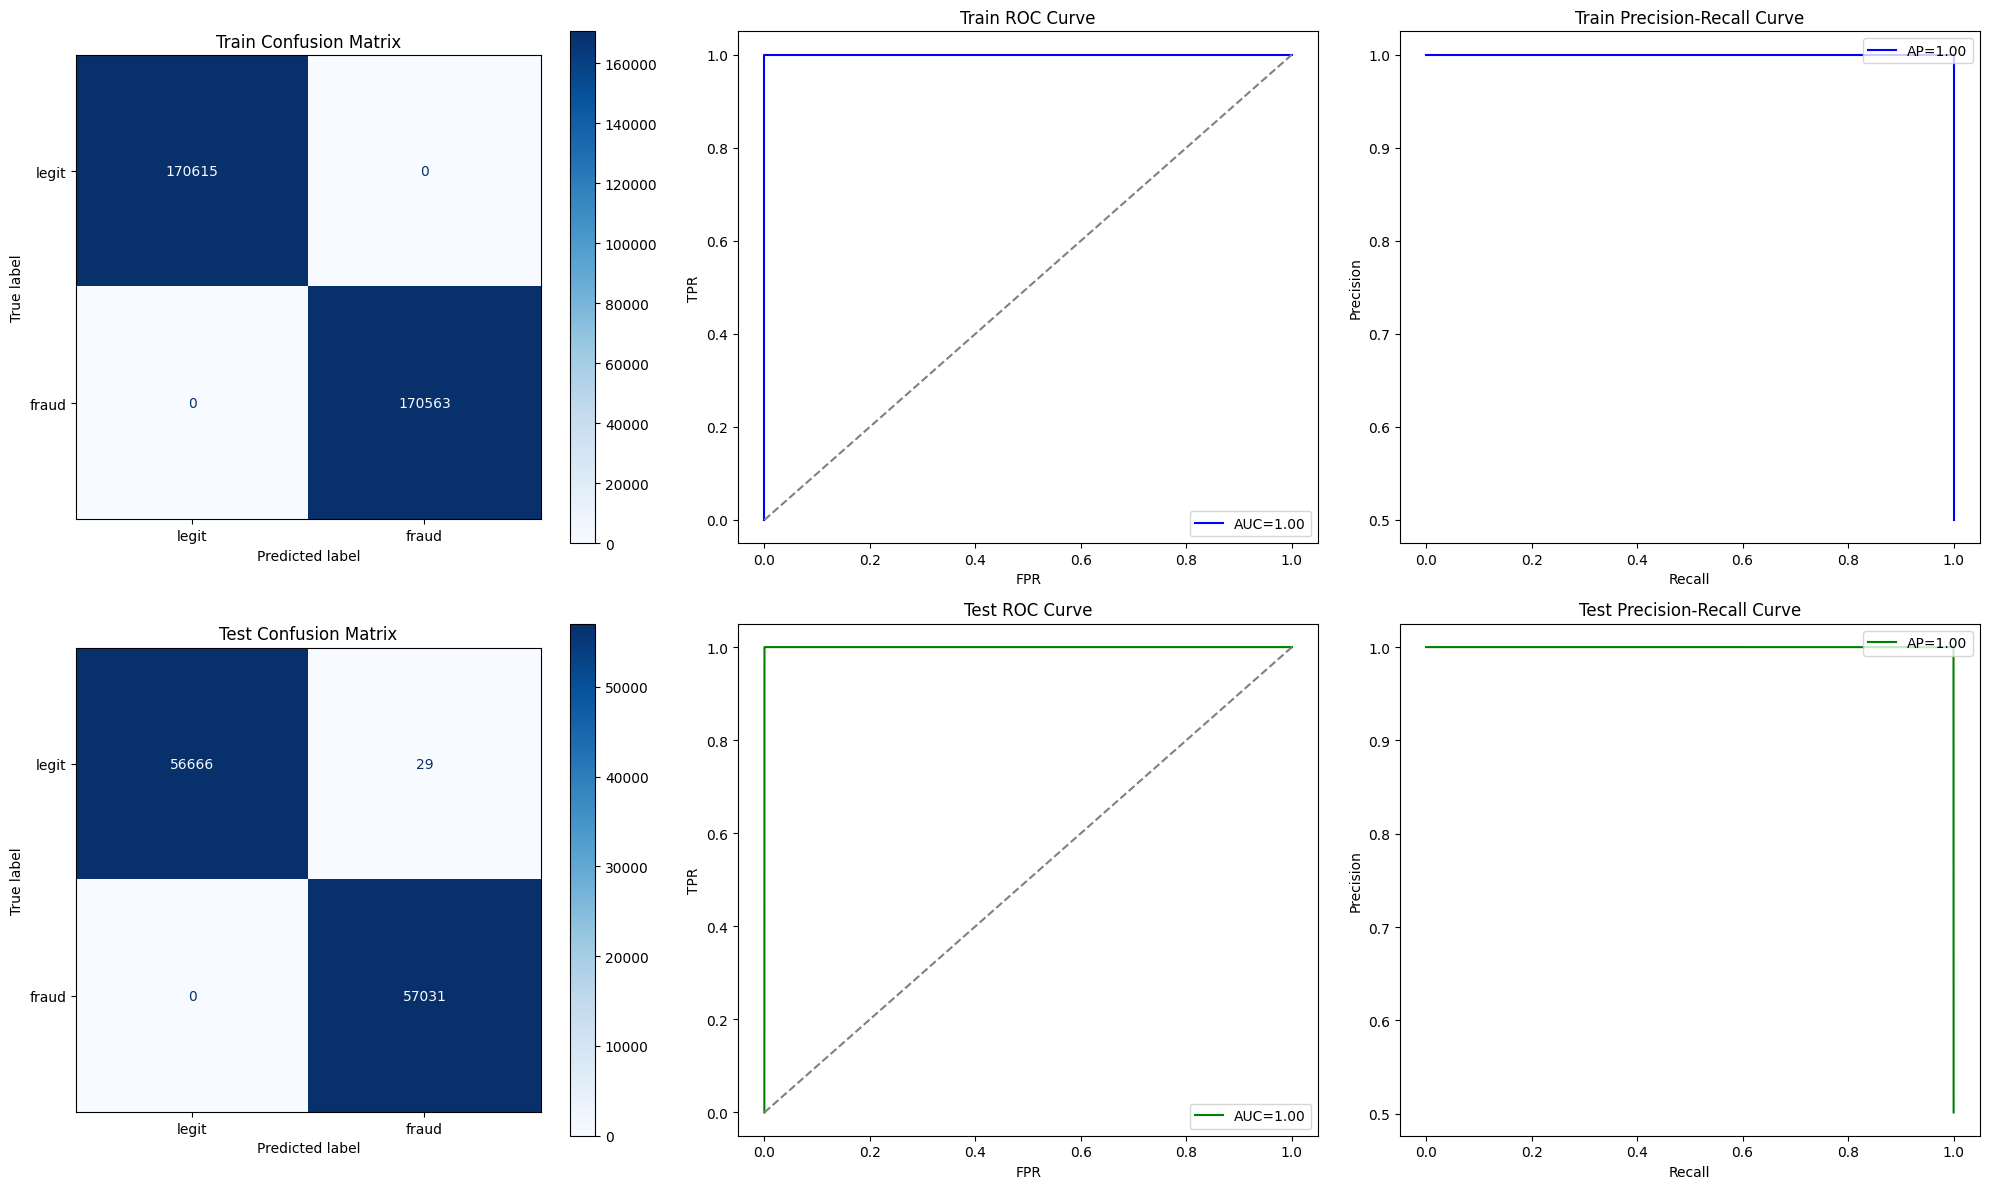

In [44]:
evaluate_model(grid_forest_u.best_estimator_,X_train_u, y_train_u, X_test_u, y_test_u,['legit','fraud'])

### XG Boost

In [45]:
model_xgb_u = XGBClassifier(random_estate=seed)
param_grid = {
    'n_estimators':[20, 50,100],
    'max_depth':[5, 15, 30],
    'learning_rate':[0.01, 0.05, 0.1],
    'gamma':[0, 0.1, 0.2]
}

grid_xgb_u = GridSearchCV(estimator=model_xgb_u, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

grid_xgb_u.fit(X_train_u, y_train_u)

print(f'''
Best params:{ grid_xgb_u.best_params_}        
Best score: {grid_xgb_u.best_score_} 
''')

c:\Users\ZonaDigital\Documents\3. Repositorios\c19-128-t-data-bi\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "random_estate" } are not used.

  warnings.warn(smsg, UserWarning)



Best params:{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100}        
Best score: 0.9999560756573702 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


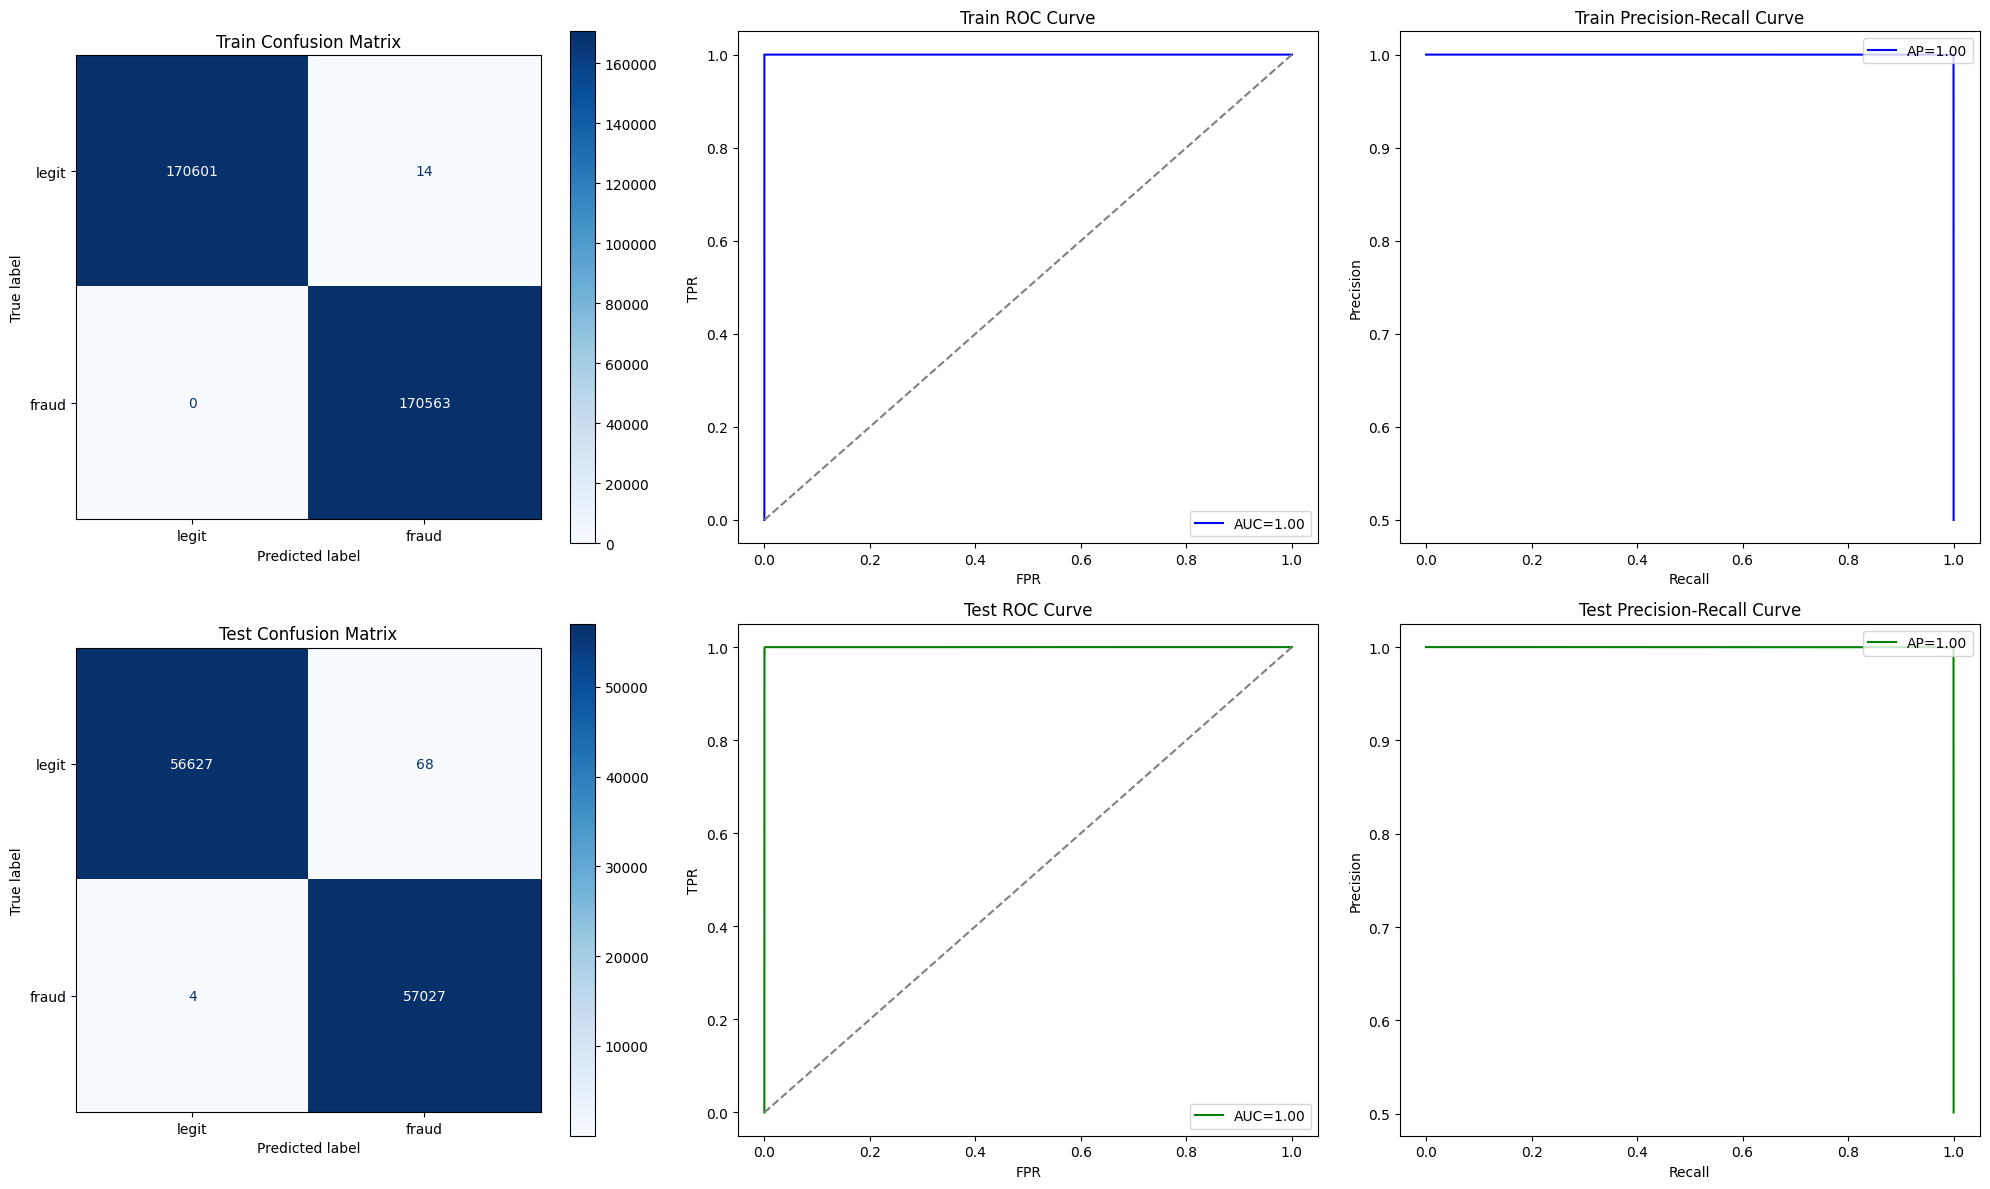

In [46]:
evaluate_model(grid_xgb_u.best_estimator_,X_train_u, y_train_u, X_test_u, y_test_u,['legit','fraud'])

### LightGBM

In [47]:
model_lgbm_u = LGBMClassifier(random_state=seed)
param_grid = {
    'n_estimators':[50, 150, 200],
    'max_depth':[5, 15, 30],
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9]
}
grid_lgbm_u = GridSearchCV(estimator=model_lgbm_u, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_lgbm_u.fit(X_train_u, y_train_u)

print(f'''
Best params:{ grid_lgbm_u.best_params_}        
Best score: {grid_lgbm_u.best_score_} 
''')

[LightGBM] [Info] Number of positive: 170563, number of negative: 170615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 341178, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499924 -> initscore=-0.000305
[LightGBM] [Info] Start training from score -0.000305

Best params:{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}        
Best score: 0.9998204742555137 



           train  test
Accuracy     1.0   1.0
Precision    1.0   1.0
Recall       1.0   1.0
F1           1.0   1.0


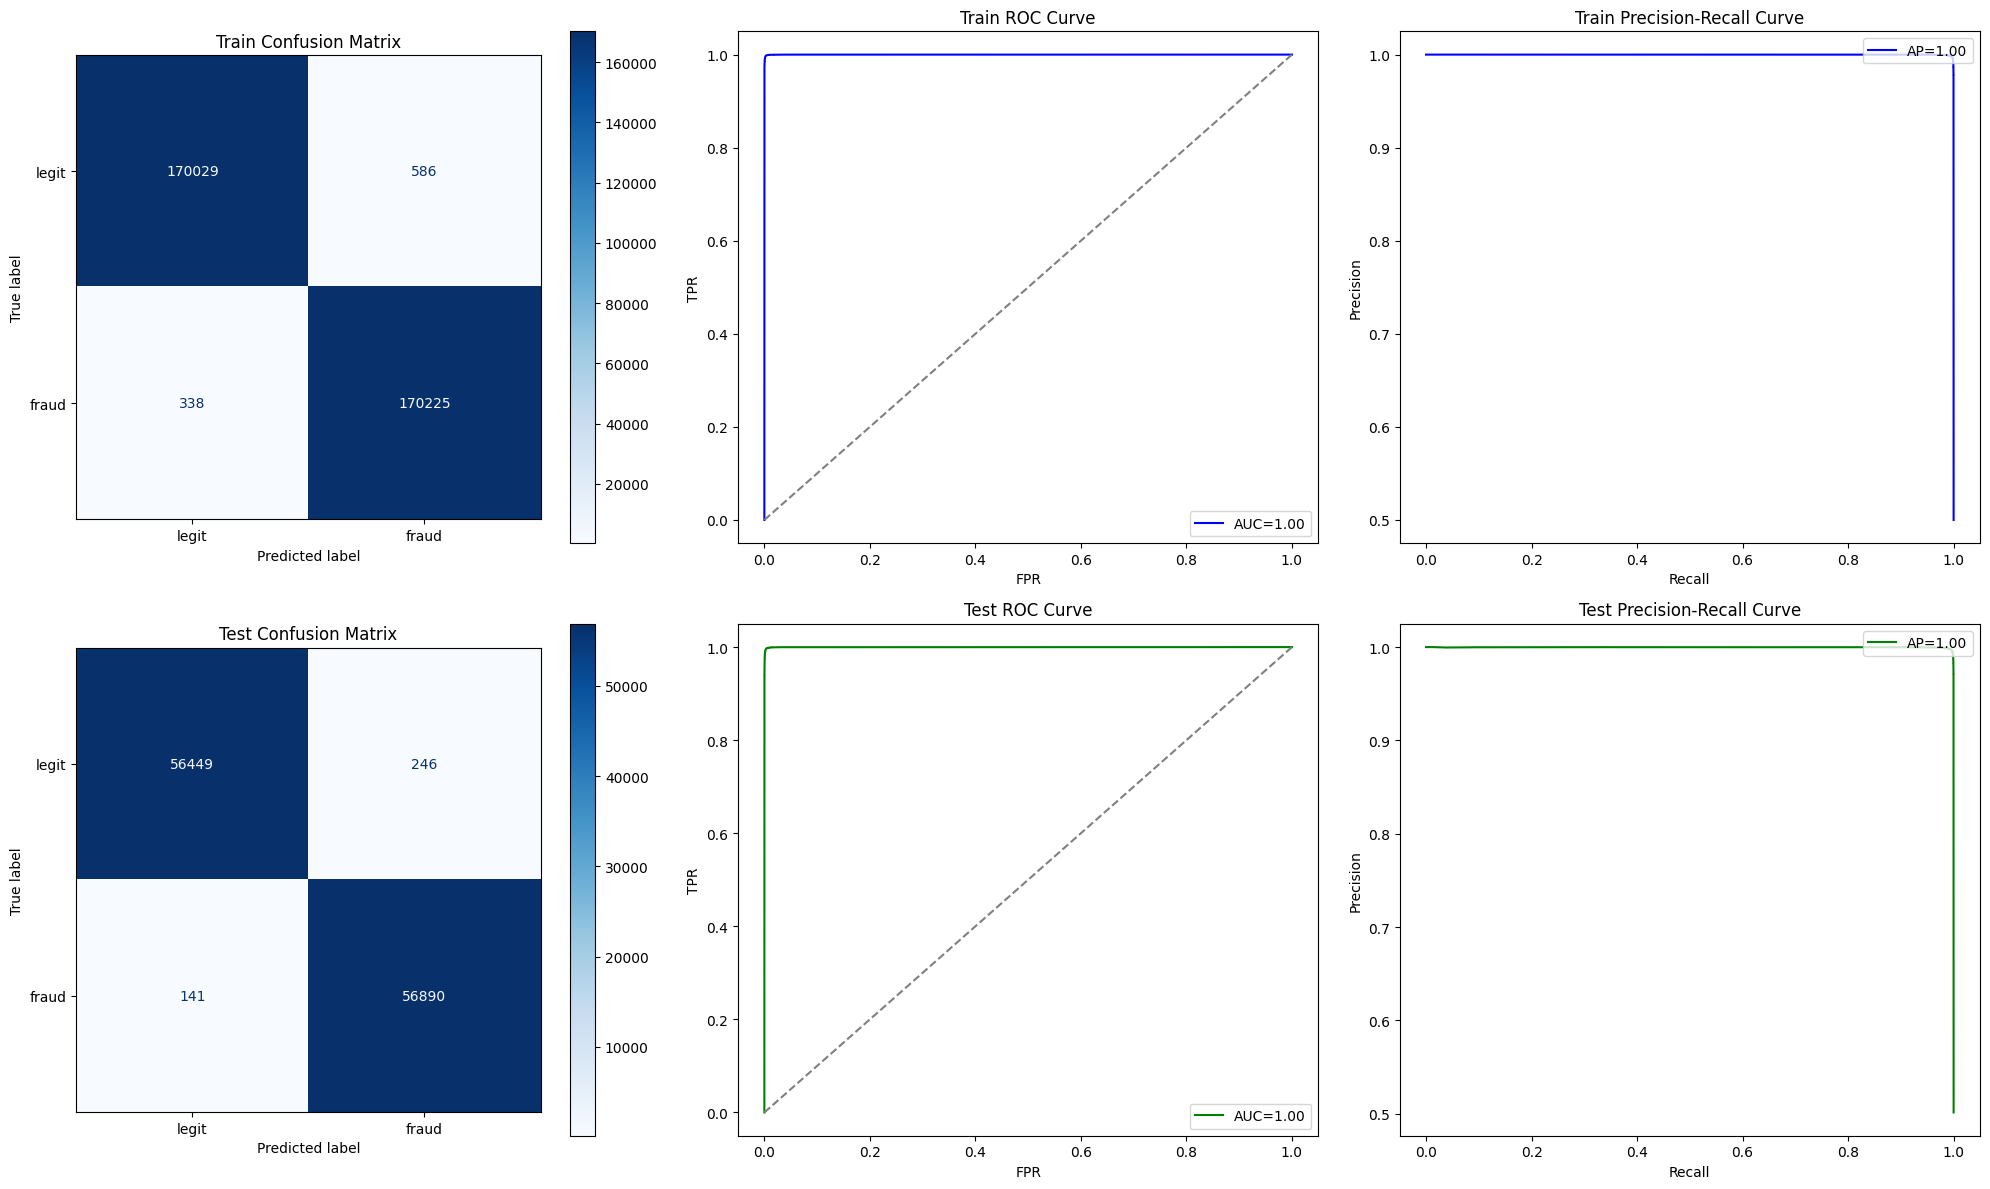

In [48]:
evaluate_model(grid_lgbm_u.best_estimator_,X_train_u, y_train_u, X_test_u, y_test_u,['legit','fraud'])